In [1]:
import torch
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt

In [2]:
class ImageFolder(ImageFolder):
    def __init__(self, root : str, transform : v2.Transform = None) -> None:
        super(ImageFolder, self).__init__(root, transform)
        self.num_classes = len(self.classes)

    def __getitem__(self, idx):
        image, label = super(ImageFolder, self).__getitem__(idx)
        one_hot_label = F.one_hot(torch.tensor(label), num_classes = self.num_classes)
        return image, one_hot_label

In [3]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.506), (0.229, 0.214, 0.220))
])

root_dir = "data"
dataset = ImageFolder(root = root_dir, transform = transform)
print(len(dataset))
print(len(dataset.classes))


539826
1000


In [4]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [5]:
images, labels = next(iter(dataloader))
print(images.shape, labels.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1000])


In [6]:
labels

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [7]:
def visualize(images, labels):
    plt.figure(figsize=(10, 10))
    for idx, (image, label) in enumerate(zip(images, labels)):
        if idx >= 9:
            break
        plt.subplot(3, 3, idx+1)
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.title(dataset.classes[torch.argmax(label).item()])
        plt.axis("off")

In [8]:
from torch.utils.data import random_split
train_ratio = 0.8
val_ratio = 0.2

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

431860 107966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.5237315].
Clipping input data to the valid 

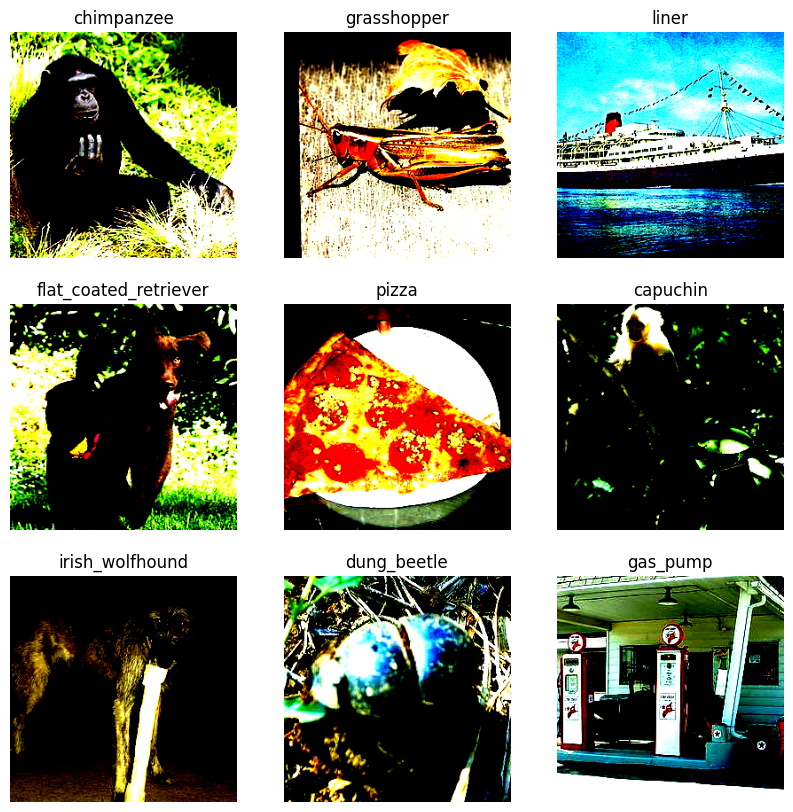

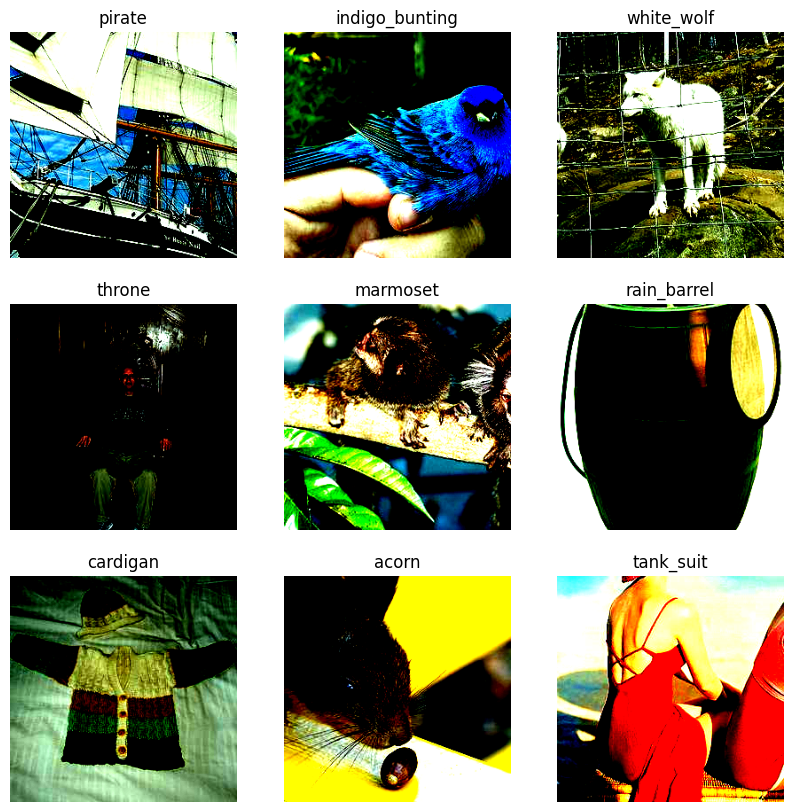

In [9]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

images, labels = next(iter(train_loader))
visualize(images, labels)
images, labels = next(iter(val_loader))
visualize(images, labels)

c:\Users\sharm\Python Projects\Research Papers\Diffusion Transformer\.venv\Lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3..2.542056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21520865..1.0218977].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22.532623..16.48115].


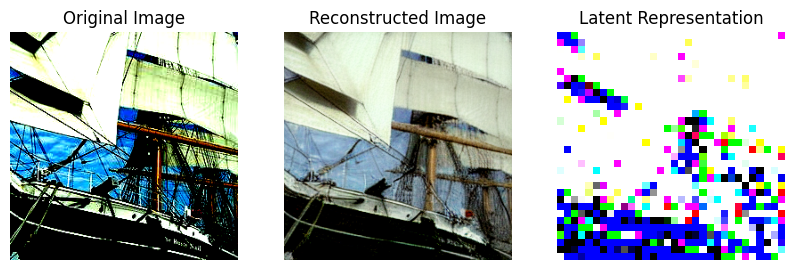

In [10]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
input_image = images[0].unsqueeze(0).to(device) 
z = vae.encode(input_image).latent_dist.sample()
reconstructed_image = vae.decode(z).sample
reconstructed_image = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach()

reconstructed_image = (reconstructed_image + 1.0) / 2.0  

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(input_image.squeeze(0).permute(1, 2, 0).cpu())
plt.title("Original Image")
plt.axis("off")


plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(z.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.title("Latent Representation")
plt.axis("off")

plt.show()


In [11]:
print(z.shape)
print(reconstructed_image.shape)

torch.Size([1, 4, 32, 32])
torch.Size([256, 256, 3])
